In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
rep1_site = promoter[(115):(115+10)]
rep2_site = promoter[(115+20):(115+30)]

#promoter = promoter.replace(rep2_site, 'G'+ rep1_site[1:])
#rep2_site = 'G' + rep1_site[1:]

r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [6]:
def doublerep_pbound_xor(p_seq, r1_seq, r2_seq, n_NS, n_p, n_r1, n_r2,
                        p_emat, r1_emat, r2_emat, 
                        ep_wt, er1_wt, er2_wt, e_int_r1r2):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
    w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)

    z = np.zeros(8)
    z[0] = 1
    z[1] = n_p / n_NS * w_p # ON
    z[2] = n_r1 / n_NS * w_r1
    z[3] = n_r2 / n_NS * w_r2
    z[4] = (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1)
    z[5] = (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)
    z[6] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int_r1r2)
    z[7] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * (n_p / n_NS * w_p) * np.exp(-e_int_r1r2) # ON
    pbound = (z[1] + z[7]) / np.sum(z)

    return pbound

In [7]:
num_mutants = 200

mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [8]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = 5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

signal_r1 = np.zeros((len(l_n_r1), num_mutants))
signal_r2 = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, doublerep_pbound_xor,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        signal_r1[i, j] = np.mean(footprint[(115):(115+10)])
        signal_r2[i, j] = np.mean(footprint[(115+20):(115+30)])

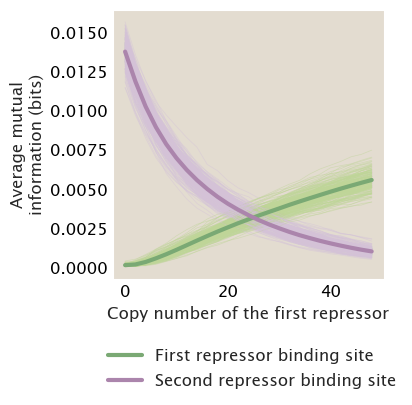

In [9]:
fig, ax = plt.subplots(figsize=(3.5,3.5))

for i in range(num_mutants):
    ax.plot(l_n_r1, signal_r1[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax.plot(l_n_r1, signal_r2[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax.plot(l_n_r1, np.mean(signal_r1, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax.plot(l_n_r1, np.mean(signal_r2, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)

ax.set_xlabel('Copy number of the first repressor', fontsize=12)
ax.set_ylabel('Average mutual\ninformation (bits)', fontsize=12)

ax.legend(bbox_to_anchor=(1.1, -0.2), frameon=False, fontsize=12)

#plt.tight_layout()
plt.savefig('../plots/figS8/double_repression_xor.pdf', bbox_inches='tight')

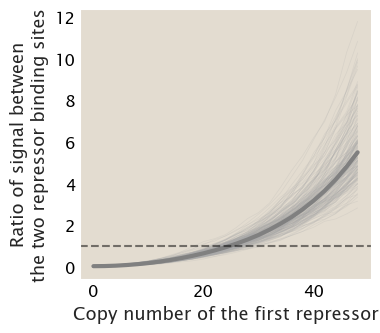

In [16]:
fig, ax = plt.subplots(figsize=(3.75,3.5))

for i in range(num_mutants):
    ax.plot(l_n_r1, np.asarray(signal_r1)[:, i] / np.asarray(signal_r2)[:, i],
            color='darkgrey', alpha=0.2, linewidth=0.5)
ax.plot(l_n_r1, np.mean(signal_r1, axis=1) / np.mean(signal_r2, axis=1),
        color='grey', linewidth=3)
ax.axhline(y=1, color='black', linestyle='--', alpha=0.5)
#ax.axvline(x=25, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('Ratio of signal between\nthe two repressor binding sites', fontsize=13)
ax.set_xlabel('Copy number of the first repressor', fontsize=13)

#plt.tight_layout()
plt.autoscale()
plt.savefig('../plots/figS8/double_repression_xor_ratio.pdf', bbox_inches='tight')

In [11]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = 5
n_p, n_r2 = 5000, 25

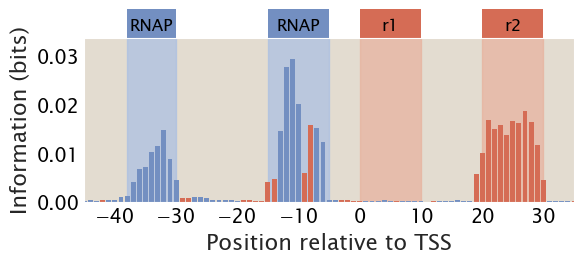

In [51]:
n_r1 = 0

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../rebuttal_plots/figR4_fp1.pdf')

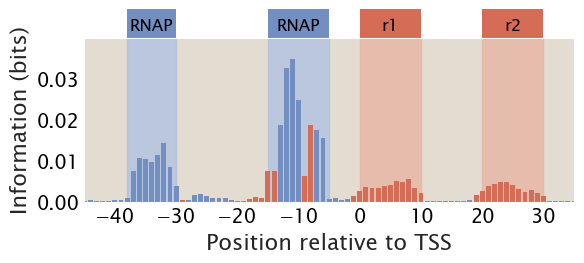

In [54]:
n_r1 = 25

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../rebuttal_plots/figR4_fp2.pdf')

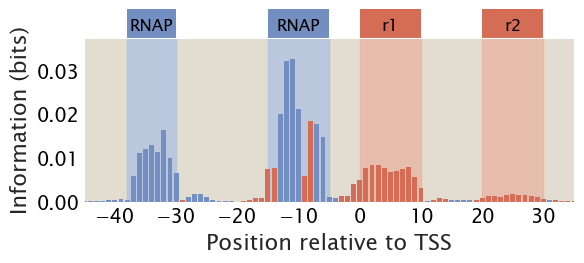

In [53]:
n_r1 = 50

df = tregs.simulate.sim(promoter, doublerep_pbound_xor, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../rebuttal_plots/figR4_fp3.pdf')